In [7]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import cftime
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')

In [27]:
# Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,memory="16GB")
client = Client(cluster)
cluster.scale(cores=8)
#cluster.adapt(minimum=2, maximum=16)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.136:36151,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [47]:
ls ../tropical_pacific_carbon_export_code/processed/flux

avg_npp_rg_cafe.nc    chl.nc                       npp.nc
avg_npp_rg_cbpm.nc    fratios.nc                   pco2grams.nc
avg_npp_rg_eppley.nc  JMA_mooring_co2_flux.nc      tpca.nc
avg_npp_rg_vgpm.nc    landsch_mooring_co2_flux.nc  zeu.nc


In [4]:
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-20,20))
#eqpac.time
eqpac=eqpac.sel(ensemble=25)

In [5]:
eqpac.surface_phy

<xarray.DataArray 'surface_phy' (time: 720, lat: 98, lon: 170)>
dask.array<getitem, shape=(720, 98, 170), dtype=float32, chunksize=(1, 98, 170), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * time      (time) object 1960-01-16 12:00:00 ... 2019-12-16 12:00:00
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -19.36 -18.59 -17.85 -17.15 ... 17.85 18.59 19.36
Attributes:
    cell_methods:  time: mean
    coordinates:   geolon_t geolat_t
    long_name:     phy
    units:         mmol/m^3
    valid_range:   [-1000000.0, 1000000.0]

In [13]:
ls ../external_data/chl/TPCA/modis

tpca_seawifs_2002.nc  tpca_seawifs_2008.nc  tpca_seawifs_2014.nc
tpca_seawifs_2003.nc  tpca_seawifs_2009.nc  tpca_seawifs_2015.nc
tpca_seawifs_2004.nc  tpca_seawifs_2010.nc  tpca_seawifs_2016.nc
tpca_seawifs_2005.nc  tpca_seawifs_2011.nc  tpca_seawifs_2017.nc
tpca_seawifs_2006.nc  tpca_seawifs_2012.nc  tpca_seawifs_2018.nc
tpca_seawifs_2007.nc  tpca_seawifs_2013.nc  tpca_seawifs_2019.nc


In [14]:
modis_tpca=xr.open_mfdataset('../external_data/chl/TPCA/modis/*nc')

In [21]:
modis_tpca

<xarray.Dataset>
Dimensions:   (time: 6226, lon: 2040, lat: 240)
Coordinates:
  * time      (time) datetime64[ns] 2002-07-04 2002-07-05 ... 2019-07-27
  * lon       (lon) float32 120.0 120.1 120.2 120.3 ... 289.7 289.8 289.9 290.0
  * lat       (lat) float32 9.958 9.875 9.792 9.708 ... -9.792 -9.875 -9.958
Data variables:
    chl_tpca  (time, lat, lon) float32 dask.array<chunksize=(174, 240, 2040), meta=np.ndarray>
Attributes: (12/25)
    history:              TPCA applied to http://oceandata.sci.gsfc.nasa.gov
    institution:          University of Tasmania - IMAS
    Conventions:          CF-1.7, ACDD-1.3
    creator_name:         Nicholas Pittman
    creator_email:        Nic.Pittman@utas.edu.au
    title:                Tropical Pacific Chlorophyll Algorithm (TPCA): Repr...
    ...                   ...
    id:                   http://dx.doi.org/10.25914/5dccbd3b64bdc
    references:           Pittman, Nic, 2019: Tropical Pacific Chlorophyll Al...
    geospatial_lon_min:   150.0
    geospatial_lon_max:   -90.0
    source:               TPCA algorithm: https://github.com/nicpittman/TPCA_...
    date_created:         2019-08-01

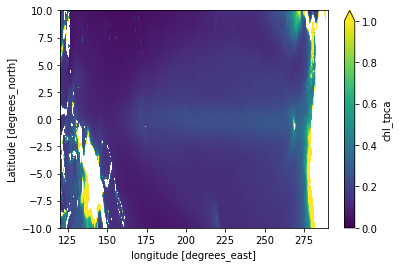

In [26]:
modis_tpca.sel(time=slice(np.datetime64('2010-01-01'),np.datetime64('2018-12-31'))).mean(dim='time').chl_tpca.plot(vmin=-0,vmax=1)
#mg/chl/m3

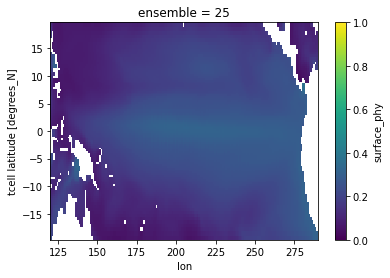

In [33]:
eqpac.surface_phy.sel(time=slice(cftime.DatetimeJulian(2010, 1, 1),cftime.DatetimeJulian(2018, 12, 31))).mean(dim='time').plot(vmin=0,vmax=1)
#mmol/M3?

In [28]:
eqpac.pprod_.sel(time=slice(cftime.DatetimeJulian(2010, 1, 1),cftime.DatetimeJulian(2018, 12, 31))).mean(dim='time').plot(vmin=0,vmax=1)
#mmol/M3?

In [117]:
eqpac.export_prod #mmolN/m^2/s
# Whereas the f-ratios 

<xarray.DataArray 'export_prod' (time: 720, lat: 98, lon: 170)>
dask.array<getitem, shape=(720, 98, 170), dtype=float32, chunksize=(1, 98, 170), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * time      (time) object 1960-01-16 12:00:00 ... 2019-12-16 12:00:00
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -19.36 -18.59 -17.85 -17.15 ... 17.85 18.59 19.36
Attributes:
    cell_methods:  time: mean
    coordinates:   geolon_t geolat_t
    long_name:     Organic export through 100m
    units:         mmolN/m^2/s

In [34]:
# CAFE650 UNITS

#export_prod	mmolN/m^2/s
#pprod_gross	mmolN/m^3/s
#pprod_gross_2d	mmolN/m^2/s

In [60]:
ls datasets/npp_satellite/cafe_mod_nc/

cafe_mod/     cbpm_mod_nc/    eppley_mod/     eppley_viirs_nc/  vgpm_viirs/
cafe_mod_nc/  cbpm_sw/        eppley_mod_nc/  vgbm_sw/          vgpm_viirs_nc/
cafe_sw/      cbpm_sw_nc/     eppley_sw/      vgbm_sw_nc/
cafe_sw_nc/   cbpm_viirs/     eppley_sw_nc/   vgpm_mod/
cbpm_mod/     cbpm_viirs_nc/  eppley_viirs/   vgpm_mod_nc/


In [107]:
#sst=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.eqpac.nc')
sst=xr.open_dataset('../processed_data/rey_eqpac_sst_rg.nc').__xarray_dataarray_variable__
npp=xr.open_dataset('../processed_data/npp_rg/avg_npp_rg_cbpm.nc').avg_npp
chl=xr.open_dataset('../processed_data/obs/TPCA_month_regrid.nc').seawifs_tpca

In [72]:
#tpca=xr.merge([chl.seawifs_tpca,chl.modis_tpca])

In [109]:
#CALC DIFFERENT f-ratio ALGOS. Need to multiply these ratios with the new prodution rate to get export flux.
zeu1= 34*chl**-0.39#lee 2007
zeu2=38*chl**-0.428#Morel 1989
pe_dunne=-0.0101*sst+0.0582*np.log(npp/zeu1)+0.419
pe_dunne2=-0.0101*sst+0.0582*np.log(npp/zeu2)+0.419
pe_dunne3=0.0081*sst+0.0668*np.log(chl/zeu2)+0.426
f_ratio=(0.62-(0.02*sst))
th_e_ratio=(0.23*np.exp(-0.08*sst))
laws2011a=((0.5857-0.0165*sst)*npp)/(51.7+npp)
laws2011b=0.04756*(0.78-((0.43*sst)/30))*npp**0.307 #avgnpp

In [13]:
ls ../external_data/fratios

SIMPLE_TRIM_output.nc


In [21]:
simpleTrim=xr.open_dataset('../external_data/fratios/SIMPLE_TRIM_output.nc')

Can't create file '../external_data/fratios/SIMPLE_TRIM_output.nc.923a8.idx'
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cfgrib/messages.py", line 239, in __iter__
    yield self.message_from_file(file, errors=self.errors)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cfgrib/messages.py", line 255, in message_from_file
    return self.message_class.from_file(file, offset, **kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cfgrib/messages.py", line 102, in from_file
    raise EOFError("End of file: %r" % file)
EOFError: End of file: <_io.BufferedReader name='../external_data/fratios/SIMPLE_TRIM_output.nc'>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cfgrib/mes

EOFError: No valid message found in file: '../external_data/fratios/SIMPLE_TRIM_output.nc'

FileNotFoundError: [Errno 2] No such file or directory: b'/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/gdata_xv83/external_data/fratios/SIMPLE_TRIM_output.nc'

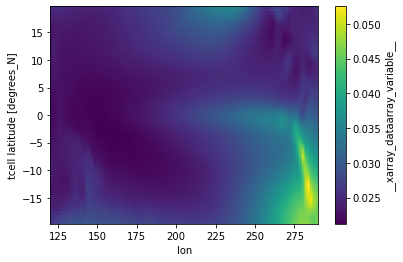

In [115]:
th_e_ratio.mean(dim='time').plot()

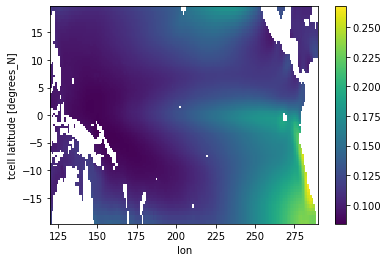

In [112]:
laws2011a.mean(dim='time').plot()

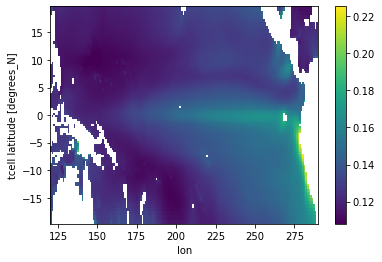

In [113]:
laws2011b.mean(dim='time').plot()

In [108]:
npp

<xarray.DataArray 'avg_npp' (time: 282, lat: 98, lon: 170)>
[4698120 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -19.36 -18.59 -17.85 -17.15 ... 17.85 18.59 19.36
  * lon      (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * time     (time) datetime64[ns] 1997-09-01 1997-10-01 ... 2021-02-01

In [101]:
npp

<xarray.Dataset>
Dimensions:  (time: 282, lat: 98, lon: 170, lat_b: 241, lon_b: 1020)
Coordinates:
  * lat      (lat) float64 -19.36 -18.59 -17.85 -17.15 ... 17.85 18.59 19.36
  * lat_b    (lat_b) float64 -20.02 -19.85 -19.68 -19.52 ... 19.68 19.85 20.02
  * lon      (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lon_b    (lon_b) float64 120.1 120.2 120.4 120.6 ... 289.5 289.6 289.8 290.0
  * time     (time) datetime64[ns] 1997-09-01 1997-10-01 ... 2021-02-01
Data variables:
    avg_npp  (time, lat, lon) float32 442.5 nan nan nan nan ... nan nan nan nan